In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
DAY=1

In [3]:
dim=(54, 4100, 1704)
def shuffle_XY(idx_date,idx_item,idx_store,X,y):
    idx=np.random.permutation(range(len(y)))
    return idx_date[idx],idx_item[idx],idx_store[idx], X[idx],y[idx]
def get_series(name):
    a=np.load("../input/s/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==dim
    return b

In [4]:
def convert_nan(X):
    idx=np.isnan(X)
    X[idx]=0
    newx=np.concatenate([X,idx],axis=1)
    newx=newx.astype(np.float16,copy=False)
    return newx
def read_data(day):
    print "read data for day", day
    dirname='../input/d'+str(day)+"/"
    y=get_series('y_0')
    cols=np.load(dirname+"cols"+".npy")
    train_test=np.load(dirname+"train_test"+".npy")
    print "loaded", y.shape,train_test.shape 
    return cols,train_test,y.astype(np.float16)

In [5]:
%time cols,train_test,y=read_data(DAY)
rawy=y

read data for day 1
loaded (54, 4100, 1704) (37, 54, 4100, 1704)
CPU times: user 4.32 s, sys: 2min 3s, total: 2min 7s
Wall time: 2min 22s


In [6]:
print "types", [u.dtype for u in (cols, train_test, y)]
print "shapes", [u.shape for u in (cols, train_test, y)]
print "mem(gb)",np.round(train_test.nbytes/1024.**3,2), np.round(y.nbytes/1024.**3,2)

types [dtype('S37'), dtype('float16'), dtype('float16')]
shapes [(37,), (37, 54, 4100, 1704), (54, 4100, 1704)]
mem(gb) 26.0 0.7


In [7]:
train_test=np.rollaxis(train_test,0,4)
print "rolled train_test shape", train_test.shape

rolled train_test shape (54, 4100, 1704, 37)


In [8]:
gc.collect()

19

In [9]:
def show_data(store,item,date):
    thisy=y[store,item,date-10:date+10]
    a=train_test[store,item,date-10:date+10,:]
    a=np.squeeze(a)
    print a.shape
    df=pd.DataFrame(a,columns=cols,index=range(date-10,date+10))
    df['target']=thisy
    with pd.option_context('display.max_columns', None):
        display(df)

In [10]:
#show_data(0,1000,1688)

# cv

In [11]:
def make_data(low,high):
    y_train=y[:,:,low:high]
    X_train=train_test[:,:,low:high,:]
    ind=~np.isnan(y_train)
    a,b=X_train[ind],y_train[ind]
    #a=a.astype(np.float32,copy=False)
    #b=b.astype(np.float32,copy=False)
    print a.shape,b.shape,a.dtype,b.dtype
    return a,b 

In [12]:
X,y=make_data(100,1688)

(121371519, 37) (121371519,) float16 float16


In [13]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [14]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [15]:
print K.floatx()

float32


In [16]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.intra_op_parallelism_threads=8
config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

In [13]:
input_dim=X.shape[1]
input_dim

NameError: name 'X' is not defined

In [17]:
class TransformNALayer(Layer):

    def __init__(self,   **kwargs):
        super(TransformNALayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(TransformNALayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        ind=tf.is_nan(x)
        filled_x=tf.where(ind, tf.zeros_like(x,dtype=np.float32), x)
        ind=tf.cast(ind,tf.float32)
        filled_x=tf.cast(filled_x,tf.float32)
        return  tf.cast(tf.concat([filled_x,ind],axis=1),tf.float32)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*2)        

In [18]:
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [19]:
def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 1.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   print "set learning rate to",lrate
   return lrate
lrate = keras.callbacks.LearningRateScheduler(step_decay)

In [17]:
#plt.plot([step_decay(u) for u in range(5)])

In [18]:
class KerasModel:
    def __init__(self,params={}):
        self.params=params
        self.model=None
    def _make_model(self):
        params=self.params
        model = Sequential()
        model.add(InputLayer(input_shape=params['input_dim']))
        model.add(TransformNALayer())
        for sz in params["hidden_layer_sizes"]:
            if params['batch_normalization']:
                model.add(BatchNormalization())
            model.add(Dense(sz,kernel_regularizer=regularizers.l2(params['l2'])))
            model.add(Dropout(params['dropout_rate']))            
            model.add(Activation(params['activation']))
        if params['loss'] == 'mean_squared_error':
            model.add(Dense(1,activation=None))
            this_loss="mean_squared_error"
            if params['metric']=="mean_squared_error":
                this_metrics=['mean_squared_error']
            else:
                raise Exception("unknown")
        else:
            raise Exception("unknown")
        model.compile(optimizer=params['optimizer'],
          loss=this_loss,
                      metrics=None)
          #metrics=this_metrics)

        self.model=model
        return self
    def fit(self,X,y):
        params=self.params
        validation_split=params['validation_split']
        patience=params['patience']
        if self.model is None:
            self._make_model()
        metric_name=self.model.metrics_names[-1]
        #print "earlystopping on "+metric_name
        self.name='day'+str(DAY)+'_adam.{epoch:02d}-{val_loss:.3f}.h5'
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
        checkpoint = keras.callbacks.ModelCheckpoint(self.name, monitor='val_loss', 
                                                     verbose=1, 
                                                     save_best_only=False, 
                                                     save_weights_only=False, 
                                                     mode='auto', period=1)        
        batch_size=params['batch_size']
        self.hist=self.model.fit(X, y, batch_size=batch_size,epochs=200, 
                       validation_split=validation_split, 
                       #validation_data=(X_valid,y_valid),
                       callbacks=[early_stopping,checkpoint],verbose=1)
        return self
    def load_best(self):
        return keras.models.load_model(self.name,
                                       custom_objects={'TransformNALayer':TransformNALayer})
    

In [27]:
param_grid={'input_dim':[(input_dim,)],
            'batch_size':[1024],
            'hidden_layer_sizes': [(256,),()],
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "validation_split":[0.1],"patience":[2],
            "dropout_rate":[0.0],
            "activation":['relu'],    
            "l2":[1e-6,0],
            "epsilon":[0.1],
            'batch_normalization': [True],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
len(parameters)

12

In [28]:
parameter=parameters[0]
parameter

{'activation': 'relu',
 'batch_normalization': True,
 'batch_size': 1024,
 'dropout_rate': 0.0,
 'epsilon': 0.1,
 'hidden_layer_sizes': (256,),
 'input_dim': (37,),
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 2,
 'validation_split': 0.1}

In [29]:
def run_once(parameter):
    backend.clear_session()
    set_session(tf.Session(config=config))
    a=KerasModel(parameter)
    a._make_model()
    h=a.fit(X,y)
    return [parameter,h.history]

In [30]:
if 0:
    backend.clear_session()
    set_session(tf.Session(config=config))    
    a=KerasModel(parameter)
    a._make_model()
    from IPython.display import SVG
    from keras.utils.vis_utils import model_to_dot
    for l in a.model.layers:
        print l, l.input_shape 
    display(SVG(model_to_dot(a.model).create(prog='dot', format='svg')))
   

In [31]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=KerasModel(parameter)
a._make_model()

<__main__.KerasModel instance at 0x7f3f86917cf8>

In [32]:
a.params

{'activation': 'relu',
 'batch_normalization': True,
 'batch_size': 1024,
 'dropout_rate': 0.0,
 'epsilon': 0.1,
 'hidden_layer_sizes': (256,),
 'input_dim': (37,),
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 2,
 'validation_split': 0.1}

In [33]:
a.fit(X,y)

Train on 109234367 samples, validate on 12137152 samples
Epoch 1/200
109234367/109234367 [==============================] - 786s 7us/step - loss: 0.2552 - val_loss: 0.2632
Epoch 2/200
109234367/109234367 [==============================] - 740s 7us/step - loss: 0.2528 - val_loss: 0.2634
Epoch 3/200
109234367/109234367 [==============================] - 744s 7us/step - loss: 0.2524 - val_loss: 0.2614
Epoch 4/200
109234367/109234367 [==============================] - 739s 7us/step - loss: 0.2523 - val_loss: 0.2608
Epoch 5/200
109234367/109234367 [==============================] - 741s 7us/step - loss: 0.2522 - val_loss: 0.2603
Epoch 6/200
109234367/109234367 [==============================] - 739s 7us/step - loss: 0.2521 - val_loss: 0.2613
Epoch 7/200
109234367/109234367 [==============================] - 745s 7us/step - loss: 0.2521 - val_loss: 0.2625


<__main__.KerasModel instance at 0x7f3f86917cf8>

In [20]:
XX=X[-1000000:]
yy=y[-1000000:]

In [38]:
from sklearn.metrics import mean_squared_error
amodel=keras.models.load_model('day1_adam.07-0.263.h5',custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
yy_pred1=amodel.predict(XX,4096)[:,0]
mean_squared_error(yy,yy_pred1)

0.2529352

In [39]:
from sklearn.metrics import mean_squared_error
amodel=keras.models.load_model('day1_adam.06-0.261.h5',custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
yy_pred2=amodel.predict(XX,4096)[:,0]
mean_squared_error(yy,yy_pred2)

0.2524499

In [40]:
from sklearn.metrics import mean_squared_error
amodel=keras.models.load_model('day1_adam.05-0.260.h5',custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
yy_pred3=amodel.predict(XX,4096)[:,0]
mean_squared_error(yy,yy_pred3)

0.25365666

In [42]:
mean_squared_error(yy,(yy_pred2+yy_pred3)/2)

0.25249055

In [51]:
train_test.shape

(54, 4100, 1704, 37)

In [54]:
amodel=keras.models.load_model('day1_adam.07-0.263.h5',custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
for i in range(1666,1688):
    ax=train_test[:,:,i].reshape([-1,train_test.shape[-1]])
    ay=rawy[:,:,i].reshape(-1)
    yy_pred3=amodel.predict(ax,4096)[:,0]
    print i,mean_squared_error(ay[~np.isnan(ay)],yy_pred3[~np.isnan(ay)])

1666 0.248161
1667 0.246508
1668 0.268801
1669 0.264589
1670 0.248193
1671 0.24989
1672 0.250266
1673 0.262389
1674 0.253012
1675 0.267665
1676 0.259826
1677 0.241547
1678 0.244404
1679 0.254827
1680 0.251901
1681 0.244607
1682 0.26774
1683 0.254389
1684 0.24604
1685 0.237457
1686 0.243867
1687 0.242403


In [21]:
from sklearn.metrics import mean_squared_error
lst=[]
lst2=[]
lst3=[]
amodel=keras.models.load_model('day1_adam.05-0.260.h5',custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
for i in range(1500,1688):
    ax=train_test[:,:,i].reshape([-1,train_test.shape[-1]])
    ay=rawy[:,:,i].reshape(-1)
    yy_pred3=amodel.predict(ax,4096)[:,0]
    lst.append(yy_pred3.reshape(rawy.shape[:2]))
    lst2.append(~np.isnan(rawy[:,:,i]))
    lst3.append(rawy[:,:,i])
    print i,mean_squared_error(ay[~np.isnan(ay)],yy_pred3[~np.isnan(ay)])

1500 0.250769
1501 0.250693
1502 0.248693
1503 0.249829
1504 0.263647
1505 0.265325
1506 0.246964
1507 0.259041
1508 0.248704
1509 0.255737
1510 0.249162
1511 0.251115
1512 0.241527
1513 0.249878
1514 0.246881
1515 0.262579
1516 0.270994
1517 0.265521
1518 0.259641
1519 0.256522
1520 0.264558
1521 0.259001
1522 0.251662
1523 0.27192
1524 0.267188
1525 0.261038
1526 0.252328
1527 0.253485
1528 0.262033
1529 0.25658
1530 0.251396
1531 0.252769
1532 0.243381
1533 0.239912
1534 0.239527
1535 0.249628
1536 0.244934
1537 0.24106
1538 0.24655
1539 0.243586
1540 0.238547
1541 0.243
1542 0.260965
1543 0.252309
1544 0.254135
1545 0.254407
1546 0.242842
1547 0.249612
1548 0.245831
1549 0.259759
1550 0.256567
1551 0.330728
1552 0.264124
1553 0.2911
1554 0.255393
1555 0.252327
1556 0.246696
1557 0.248872
1558 0.24932
1559 0.252475
1560 0.246788
1561 0.254378
1562 0.268629
1563 0.281495
1564 0.2663
1565 0.24838
1566 0.242953
1567 0.256975
1568 0.248512
1569 0.250379
1570 0.263093
1571 0.255963
1572 

In [22]:
lst=np.array(lst)
lst2=np.array(lst2)
lst3=np.array(lst3)

In [23]:
lst.shape,lst2.shape,lst3.shape

((188, 54, 4100), (188, 54, 4100), (188, 54, 4100))

In [58]:
import cPickle as pickle
pickle.dump([lst3,lst],open("abc.pkl",'wb'))

In [30]:
def nan_less(x,c):
    ind=np.isnan(x)
    r=x<c
    r[ind]=np.nan
    return r

In [67]:
np.nanmean(lst3,dtype=float),np.nanmean(lst,dtype=float),np.nanmean(lst2,dtype=float),\
np.nanstd(lst3,dtype=float),np.nanstd(lst,dtype=float)

(1.7523239394619938,
 2.0769651884473608,
 0.47611529147206366,
 0.92051847228431039,
 0.78566041817010879)

In [59]:
np.nanmean((lst3-lst)**2)

0.25438371

In [60]:
lstd=lst3-lst

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


0.719543812105


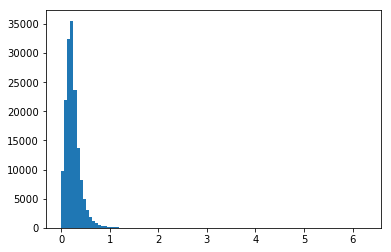

In [73]:
aaa=np.nanmean(lstd**2,0)
bbb=(~np.isnan(lstd)).sum(0)<12
aaa[bbb]=np.nan
#aaa[aaa>1]=1
print (~np.isnan(aaa)).mean()
plt.hist(aaa[~np.isnan(aaa)],bins=100);
#xlim(0,1)

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


(0, 1)

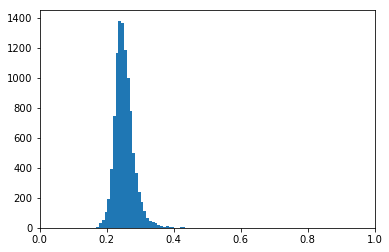

In [65]:
aaa=np.nanmean(np.rollaxis(lstd,2,0)**2,0)
aaa[aaa>1]=1
plt.hist(aaa[~np.isnan(aaa)],bins=100);
xlim(0,1)

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


(0, 1)

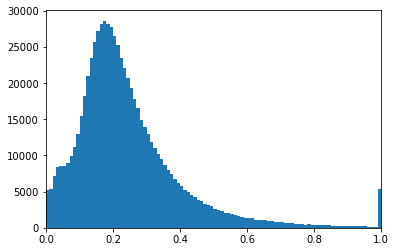

In [66]:
aaa=np.nanmean(np.rollaxis(lstd,0,2)**2,0)
aaa[aaa>1]=1
plt.hist(aaa[~np.isnan(aaa)],bins=100);
xlim(0,1)

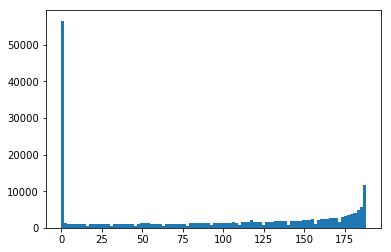

In [73]:
plt.hist(lst2.sum(0).reshape(-1),bins=100);

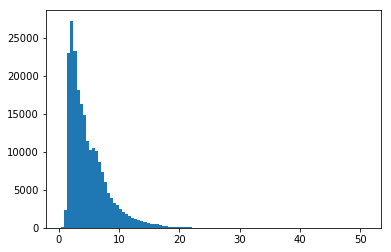

In [74]:
plt.hist((lst**2).mean(0).reshape([-1]),bins=100);

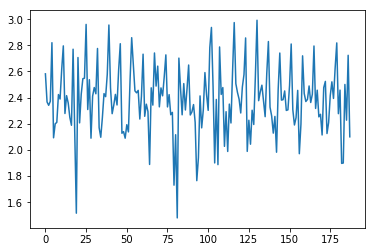

In [75]:
plt.plot(np.array(lst)[:,0,120]);

# predict

In [1]:
from sklearn.metrics import mean_squared_error

In [21]:
model = keras.models.load_model('day1.h5',
                                       custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})

In [22]:
import cPickle as pickle
stores_idx,items_idx,days_idx,states,cities,families,types = pickle.load(open("array_index.pkl"))
rev_stores={v:u for u,v in stores_idx.items()}
rev_items={v:u for u,v in items_idx.items()}
rev_days={v:u for u,v in days_idx.items()}


In [23]:
def predict_date(d):
    pred=model.predict(train_test[:,:,d].reshape([-1,36]),4096)[:,0]
    a=y[:,:,d].reshape(-1)
    return a[~np.isnan(a)],pred[~np.isnan(a)]

NameError: name 'y_valid' is not defined

In [26]:
for i in range(1600,1688):
    a,b=predict_date(i)
    print i, mean_squared_error(a,b)

1600 0.251768
1601 0.261882
1602 0.266398
1603 0.246646
1604 0.252543
1605 0.255925
1606 0.286365
1607 0.245242
1608 0.245836
1609 0.25981
1610 0.252555
1611 0.258216
1612 0.266278
1613 0.282125
1614 0.273809
1615 0.292009
1616 0.273039
1617 0.260751
1618 0.253888
1619 0.268666
1620 0.257026
1621 0.244567
1622 0.255302
1623 0.253923
1624 0.251635
1625 0.261638
1626 0.267373
1627 0.25981
1628 0.256837
1629 0.268767
1630 0.253485
1631 0.249109
1632 0.249732
1633 0.269131
1634 0.255103
1635 0.248824
1636 0.250552
1637 0.261943
1638 0.251734
1639 0.244345
1640 0.254554
1641 0.247564
1642 0.265382
1643 0.251282
1644 0.254422
1645 0.252683
1646 0.252151
1647 0.262992
1648 0.258465
1649 0.249093
1650 0.249994
1651 0.256228
1652 0.252694
1653 0.249488
1654 0.277232
1655 0.261837
1656 0.2508
1657 0.255662
1658 0.263859
1659 0.254587
1660 0.247926
1661 0.248865
1662 0.254443
1663 0.246316
1664 0.245403
1665 0.254982
1666 0.249699
1667 0.249421
1668 0.273169
1669 0.268225
1670 0.253199
1671 0.253

In [27]:
def f():
    a=np.zeros(train_test.shape[:2])
    for i in range(a.shape[0]):
        a[i]=rev_stores[i]
    b=np.zeros(train_test.shape[:2])
    for i in range(b.shape[1]):
        b[:,i]=rev_items[i]        
    return a.reshape(-1).astype(np.int),b.reshape(-1).astype(np.int)

In [28]:
rev_days[1688]

Timestamp('2017-08-16 00:00:00', freq='D')

In [29]:
a,b=f()

In [31]:
pred=model.predict(train_test[:,:,1688].reshape([-1,36]),4096)[:,0]

In [32]:
preddf=pd.DataFrame({'store_nbr':a,'item_nbr':b,'pred':pred})
preddf['date']=str(rev_days[1688].date())
preddf.head()

item_nbr      pred  store_nbr        date
0     96995  0.773942          1  2017-08-16
1     99197  0.925026          1  2017-08-16
2    103501  0.939510          1  2017-08-16
3    103520  1.032593          1  2017-08-16
4    103665  1.530042          1  2017-08-16

In [33]:
preddf.shape

(221400, 4)

In [34]:
sample=pd.read_csv("../input/test.csv").drop('onpromotion',axis=1)

In [35]:
subm=pd.merge(sample,preddf,how='left',on=['date','item_nbr','store_nbr'])

In [36]:
item_perishable_map=pd.read_csv("../input/items.csv",index_col=0)['perishable'].to_dict()
subm['perishable']=subm['item_nbr'].map(lambda u: item_perishable_map[u] )

In [37]:
subm['scaled_pred']=subm['pred']/(1+0.1180339887498949*subm['perishable'])
subm['unit_sales']=np.expm1(subm['scaled_pred'])

In [38]:
subm['unit_sales'].mean(),subm['unit_sales'].std()

(4.569568161498696, 11.528079107319696)

In [39]:
submission=subm[['id','unit_sales']].fillna(0).set_index('id')

In [45]:
a=(submission-pd.read_csv("../submission/day1.csv",index_col=0))

/home/bo/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [50]:
a['unit_sales'].describe()

count    3.370464e+06
mean    -2.234587e-03
std      3.707046e-01
min     -5.932135e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.234816e+02
Name: unit_sales, dtype: float64

In [41]:
train_test.shape

(54, 4100, 1704, 36)

In [42]:
pred.mean(),pred.std()

(1.4311662, 0.66220558)

In [43]:
np.expm1(pred).mean()

5.2493401

In [150]:
a=submission['unit_sales'].values
a[a>0].mean(),a[a>0].std(),sum(a>0)

(4.9012503589478786, 11.972409299694, 210654)

In [148]:
a=pd.read_csv("../submission/median_ma8_day0.csv",index_col=0).values
a[a>0].mean(),a[a>0].std(),sum(a>0)

(4.2958050686688392, 10.627020537041084, 149704)

In [149]:
a=pd.read_csv("../submission/day1.csv",index_col=0).values
a[a>0].mean(),a[a>0].std(),sum(a>0)

(4.6053215585907905, 10.735157033875664, 210654)